In [10]:
using LinearAlgebra
using Plots
using Measures
#using Kronecker
⊗(a,b) = kron(a,b)

⊗ (generic function with 1 method)

In [11]:
μm = 10^-6; GHz = 1; 

"""
Made racetrack_positions and PBC mutable.
racetrack_positions is 2D vector, so that we can duplicate set of racetracks
"""
struct DWLattice
    n_racetracks::Int # number of racetracks in the unit cell
    racetrack_positions::Ref{Vector{Vector{Float64}}}
    orientations::Vector{Int} # relative orientation of each domain wall;
    a::Float64 # lattice constant
    γ::Vector{Float64} # damping constant for each oscillator
    ω₀::Vector{Float64} # resonant frequency of each DW
    PBC::Ref{Bool} # periodic boundary conditions? for k-dependent Hamiltonian?
    C::Float64 # Stray-field coupling constant
    R₀::Float64 # distance between racetracks at which C was calculated
end

function init(; racetrack_positions::Vector{Vector{Float64}}, orientations::Vector{Int},
        a::Float64, γ::Vector{Float64}, ω₀::Vector{Float64}, PBC::Bool, C::Float64, R₀::Float64)
    return DWLattice(size(racetrack_positions)[1], racetrack_positions, orientations, a, γ, ω₀, PBC, C, R₀);
end

testSystem = DWLattice(2, [[0, 2.5]]*μm, [1,-1], 5*μm, [0.1,0.1]*GHz, [10,15]*GHz, true, 10^8, 2.5*μm);

In [12]:
function HO_Hamiltonian(ω₀::Float64,γ::Float64)
    H₀ = [0 1; -ω₀^2 -2*γ]
    #display(H₀)
    return H₀
end

function Coupling_Hamiltonian(C::Union{ComplexF64, Float64})
    H = [0 0; C 0]; # adds a term dₜ²x₁ = -ω₀²x₁ - 2γdₜx₁ + C*x₂
    return H
end

function constructHamiltonian(system::DWLattice, NNs::Int)
    function H(k::Union{ComplexF64,Float64})
        H₀ = zeros(ComplexF64,2*system.n_racetracks,2*system.n_racetracks)
        # add oscillators on diagonal
        for i = 1:system.n_racetracks
            ivec = zeros(system.n_racetracks); ivec[i] = 1;
            H₀ += ivec⊗(ivec')⊗HO_Hamiltonian(system.ω₀[i],system.γ[i]) 
        end
        # add coupling between oscillators
        for i = 1:system.n_racetracks
            for j = ((i-NNs):(i-1))∪((i+1):(i+NNs))
                if(j != i)
                    j_index = mod(j-1, system.n_racetracks)+1
                    dR = (floor((j-1)/system.n_racetracks))*system.a # distance of nth unit cell away
                    ΔR = abs((system.racetrack_positions[][1][i])[] - (dR + (system.racetrack_positions[][1][j_index])[])) # distance of nth racetrack
                    # make huge approximation here, say that Cij decays with 1/r² from calculated
                    # may need minus sign
                    Cij = system.orientations[i]*system.orientations[j_index]*system.C*(system.R₀/ΔR)^(2)
                    Hindex = zeros(system.n_racetracks,system.n_racetracks); Hindex[i,j_index] = 1
                    #println("i = $(i), j = $(j), J_index = $(j_index)")
                    if(j < 1 || j > system.n_racetracks)
                        if(system.PBC[])
                            H₀ += Hindex⊗Coupling_Hamiltonian(Cij*exp(im*k*dR))
                            #println("k⋅dR/(2π) = $(k*dR/(2*π))")
                        end
                    else
                        H₀ += Hindex⊗Coupling_Hamiltonian(Cij)
                    end
                end
            end
        end
        #display(H₀)
        return H₀
    end
    return H
end

constructHamiltonian (generic function with 1 method)

In [13]:
H_AFM_racetrack = constructHamiltonian(testSystem,2)

(::var"#H#15"{DWLattice, Int64}) (generic function with 1 method)

In [14]:
function plot1DBands(H::Function,system::DWLattice,nk::Int,Broadening::Bool=false, nE::Int = 200, DOS=true)
    a = system.a
    kvals = LinRange(-π/a,π/a,nk)
    ys = []
    xs = []
    maxE = maximum(imag.(eigvals(H(π/a)) ∪ eigvals(H(0.0))))
    if(Broadening)
        # get some reasonable maximum for the energies
        Evals = LinRange(0,maxE*1.1,nE)
        n = 2*system.n_racetracks
        bands = zeros(nk,nE)
        plottingBands = zeros(nk,nE)
        @Threads.threads for ik in eachindex(kvals)
            k = kvals[ik]
            Hatk = H(k)
            DOS_k(E) = (-1/π)imag.(tr(inv(E*I(n) - im*Hatk)))
            DOS_k_E = DOS_k.(Evals)
            bands[ik,:] = DOS_k_E
        end
        bands = (1/maximum(bands))*bands
        fig = heatmap(kvals*(a/π), Evals, bands', clims=(0,maximum(bands)), xlabel="k (π/a)", ylabel="Frequency (GHz)")
    end
    @Threads.threads for k in kvals
        Es = imag(eigvals(H(k)))
        append!(ys,Es/GHz)
        append!(xs,k*ones(size(Es)))
    end
    fig = scatter!(xs*(a/π),ys, legend=false,ylims=(-0.001,maxE*1.1), xlims=(-1,1), c="white", markersize=2.0, markerstrokewidth=0)
    if(DOS)
        DOS_tot = [sum(bands[:,iE]) for iE = 1:nE]; DOS_tot = (1/maximum(DOS_tot))*DOS_tot
        fDOS = plot(DOS_tot,Evals,legend=false,xlabel="DOS(ω)", ylabel="Frequency (GHz)",ylims=(-0.0001,maxE*1.1),xlims=(0,1))
    end
    fig2 = plot(fig,fDOS,layout=grid(1,2, widths=(5/8,3/8)), size=(800,300),margin=5mm)
    return fig2
end

function getBands(system::DWLattice,NNs::Int,broadening::Bool=false)
    H = constructHamiltonian(system,NNs)
    fig = plot1DBands(H,system,200,broadening)
    #display(fig)
end

getBands (generic function with 2 methods)

In [15]:
#getBands(DWLattice(2, [0, 2.5]*μm, [1,-1], 5*μm, 0.1*[1,1]*GHz, 0*[2.1,2]*GHz, true, 2*GHz, 2.0*μm),1,true);

AFM2R_lattice = init(racetrack_positions=[[0, 2.6]]*μm, orientations=[1,-1], 
    a=5*μm, γ=0.5*[1,1]*GHz, ω₀=1.0*[9,8]*GHz, PBC=true, C=10.0*GHz, R₀=2.5*μm);

AFM3R_lattice = init(racetrack_positions=[[0, 2.8, 5.0]]*μm, orientations=[1,-1,1], 
    a=7.5*μm, γ=0.5*[1,0.5,1]*GHz, ω₀=10*[0,2.0,2.1]*GHz, PBC=true, C=400.0*GHz, R₀=2.5*μm);
FM1R_lattice = init(racetrack_positions=[[0]]*μm, orientations=[1], 
    a=5*μm, γ=0.5*[1]*GHz, ω₀=10*[2.0]*GHz, PBC=true, C=80.0*GHz, R₀=2.5*μm);

Generate multiple lattice structures and return a vector of lattices.

In [16]:
function realSpaceArray(unit_cell::DWLattice, num::Int)
    # Shallow copy, creating alias
    # 1) Access Base.RefValue using[]
    # 2) Access racetrack_position vector by indexing
    orig_racetrack = unit_cell.racetrack_positions[][1]

    # Duplicate unit_cell to make supercell.
    dup_lattice = deepcopy(unit_cell)
    dup_lattice.PBC[] = false

    # Shallow copy, creating alias
    dup_racetrack = dup_lattice.racetrack_positions[][1]

    # Returns a vector of racetracks
    racetrack_arr::Ref{Vector} = []

    for i = 0:(num-1)
        # racetrack_positions is 1D array
        # Starting at 0, because of the indexing
        for j = 1:size(orig_racetrack, 1)
            new_race = i*unit_cell.a + orig_racetrack[j][]
            dup_racetrack[j] = new_race
        end
        # append dup_racetrack to the vector. Deepcopy beforehand.
        dummy = deepcopy(dup_racetrack)
        push!(racetrack_arr[], dummy)
    end

    # Replace the racetrack_position
    dup_lattice.racetrack_positions[] = racetrack_arr[]

    return dup_lattice
end

realSpaceArray (generic function with 1 method)

In [17]:
realSpaceArray(AFM2R_lattice, 2)

DWLattice(1, Base.RefValue{Vector{Vector{Float64}}}([[0.0, 2.6e-6], [4.9999999999999996e-6, 7.6e-6]]), [1, -1], 4.9999999999999996e-6, [0.5, 0.5], [9.0, 8.0], Base.RefValue{Bool}(false), 10.0, 2.4999999999999998e-6)

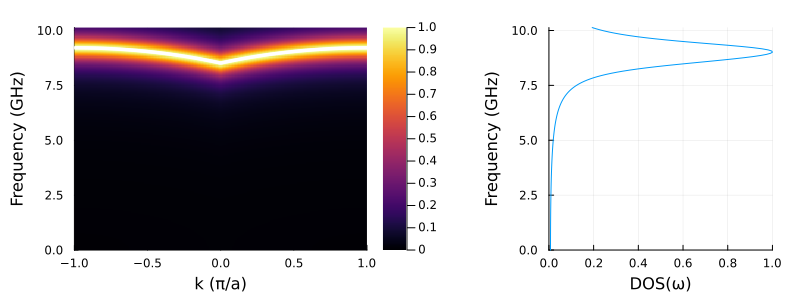

In [18]:
getBands(AFM2R_lattice,200,true)

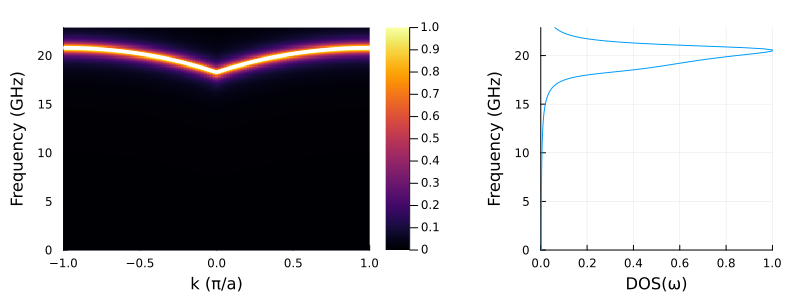

In [19]:
getBands(FM1R_lattice,2000,true)

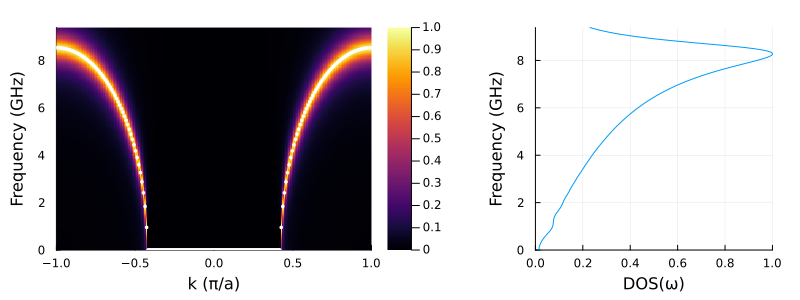

In [20]:
getBands(AFM3R_lattice,50,true)
#plot1DBands(H_AFM_racetrack,testSystem,500,false)
#plot1DBands(H_AFM_racetrack,testSystem,500,true,500)

In [21]:
pinningSweep = @animate for ω₀ in 5*collect(sin.(LinRange(0,π,100)))
    AFM3R_lattice = init(racetrack_positions=[[0, 2.8, 5.0]]*μm, orientations=[1,-1,1], 
    a=7.5*μm, γ=0.7*[1,0.5,1]*GHz, ω₀=10*[ω₀,2.0,2.1]*GHz, PBC=true, C=400.0*GHz, R₀=2.5*μm);
    getBands(AFM3R_lattice,50,true);
end

LoadError: TypeError: in keyword argument racetrack_positions, expected Vector{Vector{Float64}}, got a value of type Vector{Float64}

In [ ]:
gif(pinningSweep, "anim_fps15.gif", fps = 20)